In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
#WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing External Libraries

import numpy                             as np
import pandas                            as pd
from   numpy                         import diff
import                           cantera as ct
import tensorflow                        as tf

### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
import pyDOE
from PCAfold         import PCA          as PCAA


import romnet                            as rmnt


# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

3.9.12 (main, Mar 26 2022, 15:51:13) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


In [2]:
DataDir      = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/0DReact_Isobaric_1000Cases_H2/')

In [3]:
Data         = pd.read_csv(DataDir+'/Orig/train/ext/y.csv.1')
Data         = Data.clip(lower=1.e-30, upper=1.e10)
#SpeciesNames = list(pd.read_csv(DataDir+'/Orig/train/ext/CleanVars.csv').columns)
SpeciesNames = list(Data.columns)[1::]

YY           = Data[SpeciesNames].to_numpy()

In [4]:
QoIName  = 'N'
NPoints  = 4000

t        = np.log10(Data['t'].to_numpy())
QoI      = np.log10(np.clip(Data[QoIName].to_numpy(), 1.e-30, 1.e5))
yGrid    = np.flip( np.linspace(np.log10(Data[QoIName].min()), np.log10(Data[QoIName].max()), NPoints) )



iChange  = [False]
for it in range(1,len(QoI)-1):
    iChange.append( not ((QoI[it] - QoI[it-1])*(QoI[it+1] - QoI[it]) > 0) )
iChange.append(False)

Locs     = np.append(np.append([0], np.where(iChange)), [len(QoI)-2])

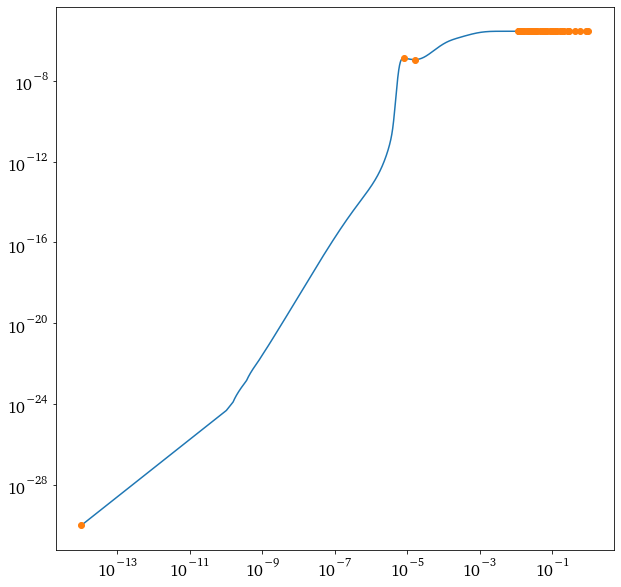

In [5]:
plt.figure(figsize=(10,10))

plt.plot(Data['t'], Data[QoIName])
plt.plot(Data['t'].iloc[Locs], Data[QoIName].iloc[Locs], 'o')
plt.xscale('log')
plt.yscale('log')

In [6]:
QoIRange     = np.abs(QoI.max()-QoI.min())

xGrid        = []
yGrid_       = []
for iLoc in range(len(Locs)-1):
    t_        = t[Locs[iLoc]:Locs[iLoc+1]+1]
    QoI_      = QoI[Locs[iLoc]:Locs[iLoc+1]+1]
    QoIRange_ = np.abs(QoI[Locs[iLoc]] - QoI[Locs[iLoc+1]+1])
    NPoints_  = np.round(QoIRange_/QoIRange*NPoints)
    if (NPoints_ > 1):  
        print(NPoints_)
        if (QoI[Locs[iLoc]] > QoI[Locs[iLoc+1]+1]):
            Sign   =  1.
        else:
            Sign   = -1.                    
        hy         = -(QoI[Locs[iLoc]] - QoI[Locs[iLoc+1]+1]) / (NPoints_-1)
        yGrid      = np.arange(QoI[Locs[iLoc]], QoI[Locs[iLoc+1]+1], hy)  
        iOrig      = Locs[iLoc]
        for y in yGrid:
            while ((QoI[iOrig] - y) * Sign >= 0) and (iOrig <= len(QoI)-2):
                iOrig += 1
            iOrig -= 1
            Deltax = t[iOrig+1]  - t[iOrig]
            Deltay = (QoI[iOrig+1] - QoI[iOrig])
            yT     = (y - QoI[iOrig])
            xT     = yT / Deltay * Deltax
            x      = t[iOrig] + xT
            xGrid.append(x)
            yGrid_.append(y)
            
    else:
        xGrid.append(t[Locs[iLoc]])
        yGrid_.append(QoI[Locs[iLoc]])

3782.0
12.0
229.0


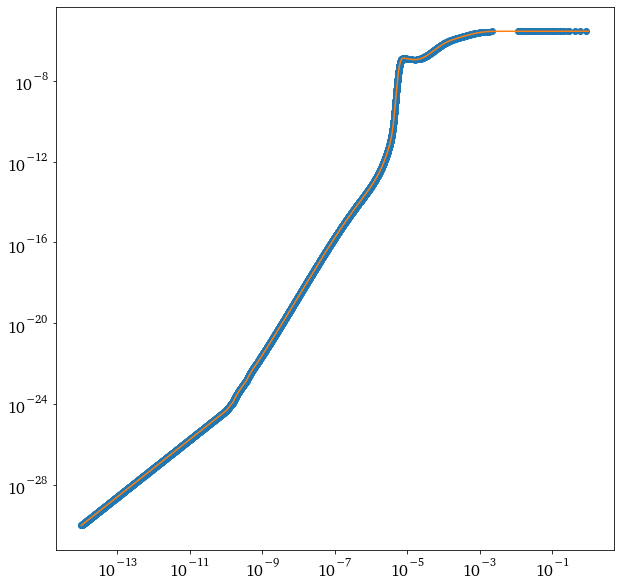

In [7]:
plt.figure(figsize=(10,10))

plt.plot(10**np.array(xGrid), 10**np.array(yGrid_), 'o')
plt.plot(Data['t'], Data[QoIName])
plt.xscale('log')
plt.yscale('log')

In [8]:
YY_   = np.zeros((len(xGrid), len(SpeciesNames)))
iOrig = 0 
for ix, x in enumerate(xGrid):
    while (x >= t[iOrig]) and (iOrig <= len(t)-2):
        iOrig += 1
    iOrig -= 1
    for iSpec in range(YY.shape[1]):
        Deltax        = t[iOrig+1] - t[iOrig]
        Deltay        = np.log10(YY[iOrig+1,iSpec]) - np.log10(YY[iOrig,iSpec])
        xT            = x - t[iOrig]
        YY_[ix,iSpec] = 10.**( np.log10(YY[iOrig,iSpec]) + xT * Deltay / Deltax )
        
DataNew      = pd.DataFrame(YY_, columns=SpeciesNames)
DataNew['t'] = 10.**np.array(xGrid)

(array([ 65.,  65.,  65.,  64.,  65.,  65.,  64.,  65.,  65.,  64.,  65.,
         65.,  64.,  65.,  88., 138., 134., 123., 129., 132., 136., 135.,
        134., 133., 129., 123., 115., 110., 119., 165., 385., 449.,  11.,
         22.,  56.,  54.,  34.,  24.,  21.,  12.,   4.,   0.,   0.,   9.,
          8.,   5.,   5.,   4.,   4.,   2.]),
 array([-14.        , -13.72120048, -13.44240096, -13.16360144,
        -12.88480192, -12.6060024 , -12.32720288, -12.04840336,
        -11.76960384, -11.49080432, -11.2120048 , -10.93320528,
        -10.65440576, -10.37560624, -10.09680672,  -9.8180072 ,
         -9.53920768,  -9.26040816,  -8.98160864,  -8.70280912,
         -8.4240096 ,  -8.14521008,  -7.86641056,  -7.58761104,
         -7.30881152,  -7.030012  ,  -6.75121248,  -6.47241297,
         -6.19361345,  -5.91481393,  -5.63601441,  -5.35721489,
         -5.07841537,  -4.79961585,  -4.52081633,  -4.24201681,
         -3.96321729,  -3.68441777,  -3.40561825,  -3.12681873,
         -2.848019

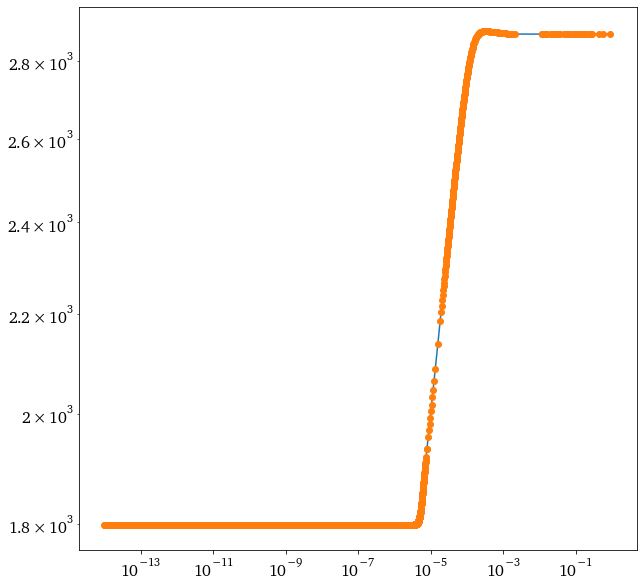

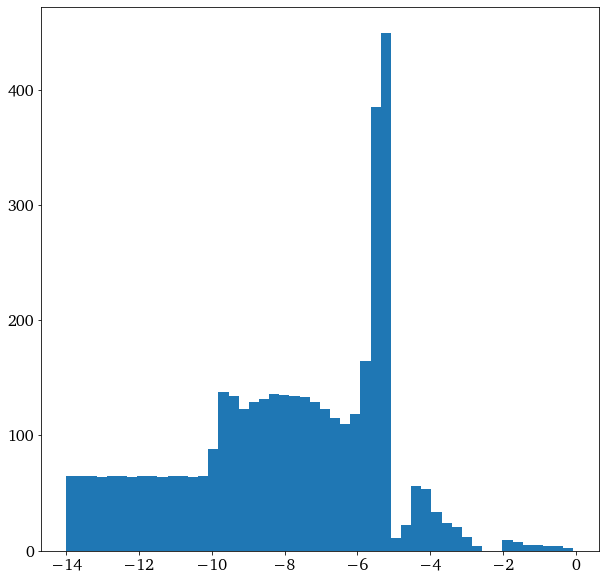

In [9]:
QoI_ = 'T'

plt.figure(figsize=(10,10))
plt.plot(Data['t'], Data[QoI_], '-')
plt.plot(DataNew['t'], DataNew[QoI_], 'o')
plt.xscale('log')
plt.yscale('log')

plt.figure(figsize=(10,10))
plt.hist(xGrid, bins=50)